# Udacity Machine Learning Nano Degree 

### Starbucks Capstone Challenge - Feature Engineering

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import math
%matplotlib inline
import os
from datetime import datetime

import boto3
import sagemaker
from sagemaker import get_execution_role

In [2]:
df = pd.read_csv('data/funnel_customer_conversion.csv', parse_dates=['member_since'])

The Offers received that was never viewed can be dropped

In [3]:
df = df.loc[(df['offer_type'] == 'transaction') | (df['time_viewed'].isnull() == False)]

df['time'] = df['time_viewed']
df.loc[df['offer_type'] == 'transaction', 'time'] = df['time_transaction']

In [4]:
df.sort_values(['person', 'time', 'offer_id'], inplace=True)

In [5]:
df.shape

(150435, 18)

In [6]:
df.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,portfolio_reward,age,gender,income,member_since
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,168.0,192.0,NaN,NaN,NaN,NaN,"['email', 'mobile', 'social']",0.0,3.0,informational,0.0,33,M,72000.0,2017-04-21
1,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,336.0,372.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",0.0,4.0,informational,0.0,33,M,72000.0,2017-04-21
4,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.0,408.0,456.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile', 'social']",5.0,5.0,bogo,5.0,33,M,72000.0,2017-04-21


### What's the Conversion Rate

Our goal is to predict the right type of offer for each client, in order to increase the Conversion Rate

We have to keep in mind that:


Few things to consider:

- We don't need to keep track of Informational offers since it doesn't have a real conversion
- If the user never see the offer it is not posible a conversion, hence only viewed offers can be considered

In [7]:
# Create feature flags
features = df.loc[:, ['offer_type', 'time_viewed', 'time_completed']]

In [8]:
features['f_viewed'] = 0
features.loc[(features['offer_type'].isin(['bogo', 'discount'])) & \
             (features['time_viewed'].isnull() == False), 'f_viewed'] = 1

In [9]:
features['f_conversion'] = 0
features.loc[(features['offer_type'].isin(['bogo', 'discount'])) & \
        (features['time_viewed'].isnull() == False) & \
        (df['time_completed'].isnull() == False),'f_conversion'] = 1

completed_offer_total = sum(features['f_conversion'])
viewed_offers_total = sum(features['f_viewed'])

print('There are {} completed offers'.format(completed_offer_total))
print('There are {} viewed offers'.format(viewed_offers_total))
print('\n\n\n Conversion Rate {}%;'.format(round((completed_offer_total / viewed_offers_total) * 100, 2)))


There are 22816 completed offers
There are 39725 viewed offers



 Conversion Rate 57.43%;


In [10]:
display(features.loc[features['f_viewed'] == 1].groupby('offer_type').agg({'f_conversion': 'mean'}))

del features

,f_conversion
offer_type,
bogo,0.504744
discount,0.657340


### Creating the tartget features

We will create 3 different columns, one for each type of offer, 1 and 0 flags, where 1 is conversion, 0 is not a conversion

In [11]:
# Lets create a feature for informationalormational offers
informational = df.loc[(df['time_viewed'].isnull() == False) | (df['time_transaction'].isnull() == False),
             ['person', 'offer_id', 'offer_type', 'time_viewed', 'time_transaction']]
informational['time'] = informational['time_viewed']
informational.loc[informational['time'].isnull(), 'time'] = informational['time_transaction']
informational.sort_values(['person', 'time', 'offer_id'], inplace=True)


informational['sub_offer_type'] = informational['offer_type'].shift(-1)
informational['sub_time'] = informational['time'].shift(-1)

# If the next record is relative to another customer, we set it as missing
informational.loc[informational['person'].shift(-1) != informational['person'], ['sub_offer_type', 'sub_time']] = ['', np.nan]

# Calculate the time difference
informational['time_diff_with_sub'] = informational['sub_time'] - informational['time_viewed']

In [12]:

# BOGO
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'bogo'), 'bogo'] = 0
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'bogo') & 
       (df['time_completed'].isnull() == False), 'bogo'] = 1

# Discount
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'discount'), 'discount'] = 0
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'discount') & 
       (df['time_completed'].isnull() == False), 'discount'] = 1

# Informational
informational.loc[informational['offer_type'] == 'informational', 'info'] = 0
informational.loc[(informational['offer_type'] == 'informational') & (informational['sub_offer_type'] == 'transaction') & \
                  (informational['time_diff_with_sub'] <= 24), 'info'] = 1

df = pd.merge(df, informational.loc[informational['info'].isnull() == False, 
                                    ['person', 'offer_id', 'time_viewed', 'info', 'sub_time']],
                                    how='left', on=['person', 'offer_id', 'time_viewed'])


df.loc[df['info'] == 1, 'time_completed'] = df['sub_time']
df.loc[df['info'] == 1, 'time_transaction'] = df['sub_time']
df.drop('sub_time', 1, inplace=True)

In [13]:
print('Recors per targets:')
print('- {} BOGO target'.format(sum(df['bogo'].isnull() == False)))
print('- {} Discount target'.format(sum(df['discount'].isnull() == False)))
print('- {} Informational target'.format(sum(df['info'].isnull() == False)))

Recors per targets:
- 21605 BOGO target
- 18120 Discount target
- 9360 Informational target


### Customer

In [14]:
customers = df[['person', 'gender', 'age', 'income', 'member_since']].drop_duplicates()

display(customers.describe(include='all').transpose())

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
person,14815,14815,e3eeb90c393a42279c6cb7e6c992ad49,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,14815,3,M,8477,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,14815,NaN,NaN,NaN,NaT,NaT,54.3931,17.3866,18,42,55,66,101
income,14815,NaN,NaN,NaN,NaT,NaT,65397.8,21598.6,30000,49000,64000,80000,120000
member_since,14815,1707,2017-08-19 00:00:00,39,2013-07-29,2018-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Building new features

In [15]:
def difference_in_month(date1, date2):
    return (date2.year - date1.year) * 12 + date2.month - date1.month

In [16]:
df['day'] = np.floor(df['time_viewed'] / 24)

# Day of week
df['dow'] = df['day'].mod(7)

# Member from
df['member_from'] = df.apply(lambda x: difference_in_month(x['member_since'], datetime(2018, 8, 1)), 1)
df.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,...,age,gender,income,member_since,bogo,discount,info,day,dow,member_from
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,168.0,192.0,NaN,NaN,NaN,NaN,"['email', 'mobile', 'social']",...,33,M,72000.0,2017-04-21,NaN,NaN,0.0,8.0,1.0,16
1,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,...,33,M,72000.0,2017-04-21,NaN,NaN,NaN,NaN,NaN,16
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,336.0,372.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",...,33,M,72000.0,2017-04-21,NaN,NaN,0.0,15.0,1.0,16
3,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,...,33,M,72000.0,2017-04-21,NaN,NaN,NaN,NaN,NaN,16
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.0,408.0,456.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile', 'social']",...,33,M,72000.0,2017-04-21,0.0,NaN,NaN,19.0,5.0,16


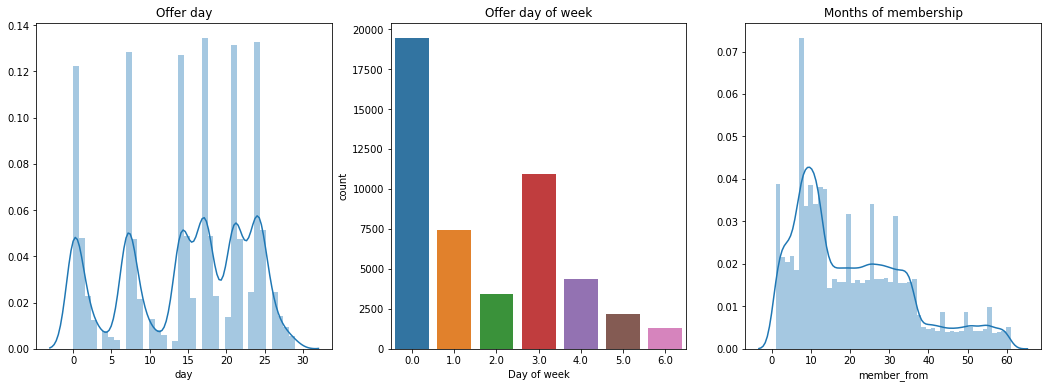

In [17]:
#Variable distribution

plt.subplots(1, 3, figsize=(18, 6))

plt.subplot(131)
plt.title('Offer day')
sns.distplot(df['day'].dropna())

plt.subplot(132)
plt.title('Offer day of week')
sns.countplot(df['dow'].dropna())
plt.xlabel('Day of week')

plt.subplot(133)
plt.title('Months of membership')
sns.distplot(df['member_from'].dropna())

plt.show()

Now we want to further analyse the customer's behavior looking at past data. 
We build a series of new features, and for each record we look at the previous ones for the same customer.

In [18]:
df.reset_index(drop=True, inplace=True)

# First, let's initialize all those features + some temporary ones to save data

# flag if the row has a transaction
df['is_transaction'] = 0 
df.loc[df['time_transaction'].isnull() == False, 'is_transaction'] = 1
# flag if the row has an offer completed
df['is_completed'] = 0
df.loc[df['time_completed'].isnull() == False, 'is_completed'] = 1

df['n_offers_completed'] = 0
df['n_offers_viewed'] = 0
df['n_transactions'] = 0
df['avg_transctions'] = 0
df['avg_reward'] = 0
df['reception_to_view'] = df['time_viewed'] - df['time_received']
df['view_to_completion'] = df['time_completed'] - df['time_viewed']
df['reception_to_view_avg'] = 0
df['view_to_completion_avg'] = 0

# Customer of previous row - to check if she's the same of the actual
df['prev_person'] = df['person'].shift(1)

for i, row in df.iterrows():
    if i % 10000 == 0: # print advancement
        print(i)
    if row['person'] == row['prev_person']: # modify data only if the previous customer is the same as current
        # Add 1 if previous offer was viewed
        df.loc[i, 'n_offers_viewed'] = df.loc[i-1, 'n_offers_viewed'] + (0 if df.loc[i-1, 'offer_type'] == 'transaction' else 1)
        # Add 1 if previous offer was completed
        df.loc[i, 'n_offers_completed'] = df.loc[i-1, 'n_offers_completed'] + df.loc[i-1, 'is_completed']
        # Add previous time from reception to view
        df.loc[i, 'reception_to_view_avg'] = np.nansum((df.loc[i-1, 'reception_to_view_avg'], 
                                                        df.loc[i-1, 'reception_to_view']))
        # Add previous time from view to completion
        df.loc[i, 'view_to_completion_avg'] = np.nansum((df.loc[i-1, 'view_to_completion_avg'], 
                                                         df.loc[i-1, 'view_to_completion']))
        # Add 1 if previous row was a transaction
        df.loc[i, 'n_transactions'] = df.loc[i-1, 'n_transactions'] + df.loc[i-1, 'is_transaction']
        # Add previous amount if previous row was a transaction
        df.loc[i, 'avg_transctions'] = df.loc[i-1, 'avg_transctions'] + (0 if df.loc[i-1, 'is_transaction'] == 0 else \
                                                                         df.loc[i-1, 'amount'])
        # Add previous reward if previous row has a reward
        df.loc[i, 'avg_reward'] = np.nansum((df.loc[i-1, 'avg_reward'], df.loc[i-1, 'reward']))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [19]:
# averages from the sums
df['reception_to_view_avg'] /= df['n_offers_viewed']
df['view_to_completion_avg'] /= df['n_offers_completed']
df['avg_transctions'] /= df['n_transactions']
df['reception_to_view_avg'].fillna(0, inplace=True)
df['view_to_completion_avg'].fillna(0, inplace=True)
df['avg_transctions'].fillna(0, inplace=True)

In [20]:
df.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,...,n_offers_completed,n_offers_viewed,n_transactions,avg_transctions,avg_reward,reception_to_view,view_to_completion,reception_to_view_avg,view_to_completion_avg,prev_person
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,168.0,192.0,NaN,NaN,NaN,NaN,"['email', 'mobile', 'social']",...,0,0,0,0.000,0.0,24.0,NaN,0.0,0.0,NaN
1,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,...,0,1,0,0.000,0.0,NaN,NaN,24.0,0.0,0009655768c64bdeb2e877511632db8f
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,336.0,372.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",...,0,1,1,22.160,0.0,36.0,NaN,24.0,0.0,0009655768c64bdeb2e877511632db8f
3,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,...,0,2,1,22.160,0.0,NaN,NaN,30.0,0.0,0009655768c64bdeb2e877511632db8f
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.0,408.0,456.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile', 'social']",...,0,2,2,15.365,0.0,48.0,NaN,30.0,0.0,0009655768c64bdeb2e877511632db8f


In [21]:
df.tail()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,...,n_offers_completed,n_offers_viewed,n_transactions,avg_transctions,avg_reward,reception_to_view,view_to_completion,reception_to_view_avg,view_to_completion_avg,prev_person
150430,ffff82501cea40309d5fdd7edcca4a07,NaN,504.0,NaN,NaN,NaN,504.0,7.79,NaN,NaN,...,4,4,11,15.910909,11.0,NaN,NaN,9.0,27.0,ffff82501cea40309d5fdd7edcca4a07
150431,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,534.0,504.0,534.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",...,4,4,12,15.234167,11.0,30.0,NaN,9.0,27.0,ffff82501cea40309d5fdd7edcca4a07
150432,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,582.0,576.0,582.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",...,4,5,12,15.234167,11.0,6.0,NaN,13.2,27.0,ffff82501cea40309d5fdd7edcca4a07
150433,ffff82501cea40309d5fdd7edcca4a07,NaN,606.0,NaN,NaN,NaN,606.0,10.12,NaN,NaN,...,4,6,12,15.234167,11.0,NaN,NaN,12.0,27.0,ffff82501cea40309d5fdd7edcca4a07
150434,ffff82501cea40309d5fdd7edcca4a07,NaN,648.0,NaN,NaN,NaN,648.0,18.91,NaN,NaN,...,4,6,13,14.840769,11.0,NaN,NaN,12.0,27.0,ffff82501cea40309d5fdd7edcca4a07


# Output

We are going to create 3 datasets, one for each target

In [22]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [23]:
features = ['gender', 'dow', 'age', 'income', 'day','member_from', 'n_transactions', 'avg_transctions',
             'n_offers_completed', 'n_offers_viewed', 'avg_reward', 'reception_to_view_avg', 'view_to_completion_avg']

targets_dict = {}
prefix = 'starbucks_challenge'
location_dict = {}
for target in ['bogo', 'discount', 'info']:
    targets_dict[target] = df.loc[df[target].isnull() == False, [target] + features]
    targets_dict[target].to_csv(f'./data/{target}.csv', index=False, header=False)
    location_dict[target] = sagemaker_session.upload_data(f'./data/{target}.csv', key_prefix=prefix)

In [24]:
location_dict

{'bogo': 's3://sagemaker-us-east-1-194598383801/starbucks_challenge/bogo.csv',
 'discount': 's3://sagemaker-us-east-1-194598383801/starbucks_challenge/discount.csv',
 'info': 's3://sagemaker-us-east-1-194598383801/starbucks_challenge/info.csv'}

In [25]:
targtes_dict = {}
for target in ['bogo', 'discount', 'info']:
    targtes_dict[target] = pd.read_csv(f'./data/{target}.csv', header=None, names=[target] + features)

In [26]:
targtes_dict['bogo']

,bogo,gender,dow,age,income,day,member_from,n_transactions,avg_transctions,n_offers_completed,n_offers_viewed,avg_reward,reception_to_view_avg,view_to_completion_avg
0,0.0,M,5.0,33,72000.0,19.0,16,2,15.365000,0,2,0.0,30.0,0.0
1,1.0,O,0.0,40,57000.0,21.0,7,3,15.823333,2,4,8.0,16.5,105.0
2,1.0,F,3.0,59,90000.0,17.0,29,4,24.582500,1,1,2.0,12.0,42.0
3,1.0,F,0.0,24,60000.0,14.0,21,5,12.572000,1,1,3.0,0.0,54.0
4,1.0,F,3.0,24,60000.0,24.0,21,11,0.000000,3,3,8.0,4.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21600,0.0,M,6.0,71,56000.0,27.0,6,5,2.430000,0,1,0.0,24.0,0.0
21601,1.0,M,0.0,34,34000.0,0.0,19,0,0.000000,0,0,0.0,0.0,0.0
21602,1.0,M,0.0,34,34000.0,21.0,19,8,6.330000,1,2,5.0,3.0,30.0
21603,0.0,M,6.0,34,34000.0,27.0,19,11,7.433636,2,3,10.0,36.0,18.0


In [27]:
targtes_dict['discount']

,discount,gender,dow,age,income,day,member_from,n_transactions,avg_transctions,n_offers_completed,n_offers_viewed,avg_reward,reception_to_view_avg,view_to_completion_avg
0,0.0,M,1.0,33,72000.0,22.0,16,3,14.946667,0,3,0.0,36.0,0.0
1,1.0,O,0.0,40,57000.0,7.0,7,1,13.490000,0,1,0.0,6.0,0.0
2,1.0,O,4.0,40,57000.0,18.0,7,2,12.710000,1,3,3.0,14.0,66.0
3,1.0,F,0.0,59,90000.0,0.0,29,0,0.000000,0,0,0.0,0.0,0.0
4,1.0,F,0.0,24,60000.0,7.0,21,1,16.270000,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18115,1.0,F,0.0,45,62000.0,0.0,21,0,0.000000,0,0,0.0,0.0,0.0
18116,1.0,F,0.0,45,62000.0,7.0,21,3,10.786667,1,1,2.0,6.0,54.0
18117,1.0,F,0.0,45,62000.0,14.0,21,8,16.091250,2,2,7.0,6.0,39.0
18118,1.0,F,3.0,45,62000.0,17.0,21,9,16.033333,3,3,9.0,10.0,36.0


In [28]:
targtes_dict['info']

,info,gender,dow,age,income,day,member_from,n_transactions,avg_transctions,n_offers_completed,n_offers_viewed,avg_reward,reception_to_view_avg,view_to_completion_avg
0,0.0,M,1.0,33,72000.0,8.0,16,0,0.000000,0,0,0.0,0.0,0.0
1,0.0,M,1.0,33,72000.0,15.0,16,1,22.160000,0,1,0.0,24.0,0.0
2,0.0,O,0.0,40,57000.0,0.0,7,0,0.000000,0,0,0.0,0.0,0.0
3,0.0,O,0.0,40,57000.0,14.0,7,2,12.710000,1,2,3.0,12.0,66.0
4,0.0,F,6.0,59,90000.0,27.0,29,6,24.905000,2,2,12.0,15.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,1.0,F,3.0,67,77000.0,17.0,18,7,0.000000,2,2,2.0,39.0,27.0
9356,0.0,M,5.0,67,80000.0,12.0,14,2,15.765000,0,0,0.0,0.0,0.0
9357,1.0,M,5.0,67,80000.0,26.0,14,5,19.960000,0,2,0.0,90.0,0.0
9358,1.0,F,1.0,69,83000.0,22.0,35,9,18.518889,1,2,2.0,24.0,0.0


## Preprocessing with scikit-learn 

- Encode categorical variable gender (One Hot encoder)
- Impute missing values
- Normalize feature distributions

In [29]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
output_configs = {}
for target in ['bogo', 'discount', 'info']:
    print(target)
    
    sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                         role=role,
                                         instance_type='ml.m5.xlarge',
                                         instance_count=1)
    sklearn_processor.run(
        code='helpers/data_preprocessing.py', #entrypoint the helper data preprocessing.py file path
        inputs=[ProcessingInput(os.path.join('s3://', bucket, f'starbucks_challenge/{target}.csv'), '/opt/ml/processing/input')],
        outputs=[
            ProcessingOutput(source=f'/opt/ml/processing/output/',
                             output_name=f'{target}_data')
        ],arguments=['--target', target]
     )

    preprocessing_job_description = sklearn_processor.jobs[-1].describe()
    output_configs[target] = preprocessing_job_description['ProcessingOutputConfig']

bogo


Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.



Job Name:  sagemaker-scikit-learn-2020-08-06-00-52-12-587
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/starbucks_challenge/bogo.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-00-52-12-587/input/code/data_preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'bogo_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-00-52-12-587/output/bogo_data', 'LocalPath': '/opt/ml/processing/output/', 'S3UploadMode': 'EndOfJob'}}]
.......................Collecting joblib
  Found existing installation: sci

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


discount

Job Name:  sagemaker-scikit-learn-2020-08-06-00-56-25-909
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/starbucks_challenge/discount.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-00-56-25-909/input/code/data_preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'discount_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-00-56-25-909/output/discount_data', 'LocalPath': '/opt/ml/processing/output/', 'S3UploadMode': 'EndOfJob'}}]
......................Collecting joblib
  Found existi

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


info

Job Name:  sagemaker-scikit-learn-2020-08-06-01-00-38-530
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/starbucks_challenge/info.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-01-00-38-530/input/code/data_preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'info_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-01-00-38-530/output/info_data', 'LocalPath': '/opt/ml/processing/output/', 'S3UploadMode': 'EndOfJob'}}]
...........................
  Found existing installation: scikit-lear

In [40]:
preprocessed_data = {}
for output in output_configs:
            preprocessed_data[output] = output_configs[output]['Outputs'][0]['S3Output']['S3Uri']
print(preprocessed_data)
print('\n\n')

# Move datasets to project specific directory
s3_client = boto3.client('s3')
for data in preprocessed_data:
    for files in ['train.csv', 'val.csv', 'test.csv', 'test_target.csv', 'transformer.joblib']:
        copy_source = {'Bucket': bucket, 'Key': '/'.join(preprocessed_data[data][5:].split('/')[1:] + [f'{data}_{files}'])}
        s3_client.copy_object(CopySource=copy_source, Bucket=bucket, Key=f'starbucks_challenge/{data}/{data}_{files}')

# Download the new datasets
for data in preprocessed_data:
    for files in ['train.csv', 'val.csv', 'test.csv', 'test_target.csv']:
        sagemaker_session.download_data(f'./data/{data}/', bucket, f'starbucks_challenge/{data}/{data}_{files}')

{'bogo': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-00-52-12-587/output/bogo_data', 'discount': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-00-56-25-909/output/discount_data', 'info': 's3://sagemaker-us-east-1-194598383801/sagemaker-scikit-learn-2020-08-06-01-00-38-530/output/info_data'}



